In [291]:
#PARAMETERS
testDataFile="/Users/eliotpbrenner/PycharmProjects/SparsityBoost/data/synthetic_examples/experiments/0/alarm1000.dat"
numTestVariable=37
numTestDataPts=1000
studentJSONFile = "student.txt"
studentDataFile="student_100kSamples.csv"
studentNValsFile="student_nvals.csv"
numStudentVariable=5
numStudentDataPts=100000

100000

In [292]:
# Imports
using Base.Test
using Iterators

In [293]:
type model
  nodes::Int64
  nval::Array{Int64,1}
  dataArray::Array{Int64,2}
end

In [294]:
type jointDistWithMarginals
  pdist::Array{Float64,2}
  p_A::Array{Float64,1}
  p_B::Array{Float64,1}
end

In [295]:
# Constructor which calculates the marginals
jointDistWithMarginals(pdist::Array{Float64,2}) = jointDistWithMarginals(pdist, vec(sum(pdist,2)), vec(sum(pdist,1)))

jointDistWithMarginals

In [296]:
jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]])

jointDistWithMarginals(2x2 Array{Float64,2}:
 0.25  0.25
 0.25  0.25,[0.5,0.5],[0.5,0.5])

In [297]:
jointDistWithMarginals([[0.25 0.125 0.125]; [ 0.25 0.125 0.125]])

jointDistWithMarginals(2x3 Array{Float64,2}:
 0.25  0.125  0.125
 0.25  0.125  0.125,[0.5,0.5],[0.5,0.25,0.25])

In [298]:
function readDataBinary(filePath::AbstractString)
  dataArray = readdlm(filePath, ' ', Int);
  nodes=size(dataArray)[2];
  nval=2*ones(Int, nodes)
  theModel = model(nodes,nval,dataArray);
end


readDataBinary (generic function with 1 method)

In [299]:
function readData(dataFilePath::AbstractString, nvalsFilePath::AbstractString)
  dataArray = readdlm(dataFilePath, ',', Int);
  nodes=size(dataArray)[2];
    nval=vec(readdlm(nvalsFilePath, ',', Int));   #2*ones(Int, nodes)
  theModel = model(nodes,nval,dataArray);
end

readData (generic function with 1 method)

In [300]:
m=readData(studentDataFile, studentNValsFile)

model(5,[2,2,3,2,2],100000x5 Array{Int64,2}:
 0  0  1  0  0
 0  0  0  1  1
 1  0  2  0  0
 0  0  2  0  0
 1  1  0  1  1
 0  0  1  0  0
 0  0  2  0  0
 0  0  0  0  1
 0  0  1  0  1
 0  0  1  0  0
 0  0  1  0  0
 0  1  0  1  1
 0  0  0  0  1
 ⋮            
 0  0  1  0  0
 1  1  2  1  0
 0  0  1  0  1
 0  0  0  0  1
 0  0  2  0  0
 0  0  1  0  0
 0  1  0  0  1
 1  1  1  1  0
 0  1  0  0  0
 1  0  1  1  0
 1  1  0  1  1
 0  0  2  0  0)

In [301]:
# test readData function
m=readData(studentDataFile, studentNValsFile)
@test size(m.dataArray) == (numStudentDataPts, numStudentVariable)

In [302]:
function verify(aJointDistributionWithMarginals::jointDistWithMarginals)
  sumA=sum(aJointDistributionWithMarginals.pdist,2)
  sumB=sum(aJointDistributionWithMarginals.pdist,1)
  @test_approx_eq(transpose(sumA),aJointDistributionWithMarginals.p_A)
  @test_approx_eq(sumB,aJointDistributionWithMarginals.p_B)
  @test_approx_eq(sum(sumA),1.0)
  return true
end

verify (generic function with 1 method)

In [303]:
goodDist=jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]], [0.5; 0.5], [0.5; 0.5])
@test verify(goodDist) == true

In [304]:
#TODO: determine why this this test fails instead of succeeding!
badDist = jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]], [0.6; 0.4], [0.5; 0.5])
@test_throws( ErrorException, verify(badDist))

ErrorException("assertion failed: |transpose(sumA) - aJointDistributionWithMarginals.p_A| <= 2.220446049250313e-12\n  transpose(sumA) = [0.5 0.5]\n  aJointDistributionWithMarginals.p_A = [0.6,0.4]\n  difference = 0.09999999999999998 > 2.220446049250313e-12")

In [305]:
function MI_term(i::Int, j::Int, dist::jointDistWithMarginals)
  return dist.pdist[i,j]*log(dist.pdist[i,j]/(dist.p_A[i]*dist.p_B[j])  )
end

MI_term (generic function with 1 method)

In [306]:
function MI(dist::jointDistWithMarginals)
  (a,b)=size(dist.pdist)
  return sum([(MI_term(i,j,dist)) for i=1:a, j=1:b])
end

MI (generic function with 3 methods)

In [307]:
function MI(m::model,i::Int,j::Int,SToVal::Dict)
  """
  TODO: test
  """
  MI(conditionalDist(m::model,i::Int,j::Int,SToVal::Dict))
end

MI (generic function with 3 methods)

In [308]:
MI(m,1,3,Dict(2=>1, 4=>1))

0.10408784888114189

In [309]:
MI_term(1,1,goodDist)

0.0

In [310]:
@test_approx_eq(MI(goodDist),0)

In [311]:
t=0.01
anotherDist=jointDistWithMarginals([[0.25+t 0.25-t]; [ 0.25-t 0.25+t]], [0.5; 0.5], [0.5; 0.5])
verify(anotherDist)
@test_approx_eq(MI(anotherDist), 0.0008002134699838133)

In [312]:
testNotInDict(elt::Int, SToVal::Dict) = try
    """TODO: figure out how to propagate y up the call stack if it's not a KeyError"""
    x=SToVal[elt] 
    warn("$elt is in $SToVal with value $x")
    throw(DomainError())
  catch y
    if isa(y, KeyError)
      return true
    else
      return y
    end
  end

testNotInDict (generic function with 1 method)

In [313]:
S=Dict(1=>2, 3=>4)

Dict{Int64,Int64} with 2 entries:
  3 => 4
  1 => 2

In [314]:
testNotInDict(1,S)

DomainError()

In [315]:
function conditionalDist(m::model,i::Int,j::Int,SToVal::Dict)
  """
  TODO: that S is a dict of integers and that both are valid for the model
  TODO: vectorize the computation of the pDist
  """
  @test i!=j
  @test testNotInDict(i, SToVal) == true
  @test testNotInDict(j, SToVal) ==true
  selectedPoints = m.dataArray[reduce(&,[m.dataArray[:,condVar] .==SToVal[condVar] for condVar in keys(SToVal)]),:]
  numSelectedPoints = size(selectedPoints)[1]
  pDist = zeros(m.nval[i], m.nval[j])
  for k = 1:m.nval[i]
      for l = 1:m.nval[j]
          pDist[k,l] = size(selectedPoints[(selectedPoints[:,i] .==k-1)&(selectedPoints[:,j] .==l-1), :])[1]/numSelectedPoints
    end
  end
    jd = jointDistWithMarginals(pDist)
    #verify(jd)
    return jd
end

conditionalDist (generic function with 1 method)

In [316]:
SToVal = Dict(2=>0, 4=>1)
cd = conditionalDist(m, 1, 3, SToVal)

jointDistWithMarginals(2x3 Array{Float64,2}:
 0.18229    0.241131  0.183444
 0.0227863  0.09576   0.274589,[0.6068647245457167,0.39313527545428323],[0.2050764349581771,0.3368906835881165,0.45803288145370635])

In [317]:
@test_throws(ErrorException,conditionalDist(m, 1, 1, SToVal))

ErrorException("test failed: 1 != 1\n in expression: i != j")

In [318]:
conditionalDist(m, 3, 1, SToVal)

jointDistWithMarginals(3x2 Array{Float64,2}:
 0.18229   0.0227863
 0.241131  0.09576  
 0.183444  0.274589 ,[0.2050764349581771,0.3368906835881165,0.45803288145370635],[0.6068647245457167,0.39313527545428323])

In [319]:
#TODO: determine why this test is failing
@test_throws(DomainError, conditionalDist(m, 3, 1, S))

LoadError: LoadError: test failed: ErrorException("test failed: DomainError() == true\n in expression: testNotInDict(i,SToVal) == true") was thrown instead of DomainError
 in expression: conditionalDist(m,3,1,S)
while loading In[319], in expression starting on line 2

In [320]:
conditionalDist(m, 3, 1, S)

LoadError: LoadError: test failed: DomainError() == true
 in expression: testNotInDict(i,SToVal) == true
while loading In[320], in expression starting on line 1

In [321]:
function MI(m::model, i::Int, j::Int, S::Array{Int64,1})
  """
  TODO: test
  """
  max=-Inf
  for p in Iterators.product([1:m.nval[k]-1 for k in S]...)
        candidate=MI(m,i,j, Dict(zip(S,p)))
    if candidate > max
      max=candidate
    end
  end
  return max
end

MI (generic function with 3 methods)

In [322]:
function epsilon(m::model, i::Int, j::Int, d::Int)
    min=Inf
    bestK=Array([])
    for di in (1:d)
        for k in combinations(1:m.nodes,di)
            if (i in k) || (j in k)
                continue
            end
            candidate = MI(m,i,j,k)
            if candidate < min
                min=candidate
                bestK=k
            end
        end
    end
    return bestK, min
end

epsilon (generic function with 2 methods)

In [323]:
epsilon(m,1,2,1)

([4],1.0097662376677198e-5)

In [324]:
using PyCall


In [325]:
@pyimport graphviz

In [326]:
ndModule = pyimport("libpgm.nodedata")

PyObject <module 'libpgm.nodedata' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/nodedata.pyc'>

In [327]:
ndObj=pycall(ndModule["NodeData"], PyCall.PyObject)

PyObject <libpgm.nodedata.NodeData object at 0x319076150>

In [328]:
pycall(ndObj["load"],PyCall.PyObject, studentJSONFile)

PyObject None

In [329]:
gsModule = pyimport("libpgm.graphskeleton")

PyObject <module 'libpgm.graphskeleton' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/graphskeleton.pyc'>

In [330]:
gsObj=pycall(gsModule["GraphSkeleton"], PyCall.PyObject)

PyObject <libpgm.graphskeleton.GraphSkeleton object at 0x319076250>

In [331]:
pycall(gsObj["load"], PyCall.PyAny, studentJSONFile )

dbnModule = pyimport("libpgm.discretebayesnetwork")
dbnObj = pycall(dbnModule["discretebayesiannetwork"], PyCall.PyAny)
adbn = pycall(dbnObj["DiscreteBayesianNetwork"], PyCall.PyObject, skel, ndb)

In [332]:
dbnModule = pyimport("libpgm.discretebayesiannetwork")


PyObject <module 'libpgm.discretebayesiannetwork' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/discretebayesiannetwork.pyc'>

In [333]:
dbnObj = pycall(dbnModule["DiscreteBayesianNetwork"], PyCall.PyAny, gsObj, ndObj)


PyObject <libpgm.discretebayesiannetwork.DiscreteBayesianNetwork object at 0x319076590>

In [334]:
V = pycall(dbnObj["__getattribute__"], Array, "V")

5-element Array{Any,1}:
 "Difficulty"  
 "Intelligence"
 "Grade"       
 "SAT"         
 "Letter"      

In [335]:
E = pycall(dbnObj["__getattribute__"], Array, "E")

4x2 Array{Any,2}:
 "Intelligence"  "Grade" 
 "Difficulty"    "Grade" 
 "Intelligence"  "SAT"   
 "Grade"         "Letter"

In [336]:
g = graphviz.Graph(format="svg")

In [337]:
pycall(g["node"], PyCall.PyObject, "Difficulty")
pycall(g["node"], PyCall.PyObject, "Grade")
pycall(g["edge"], PyCall.PyObject, "Difficulty", "Grade")

PyObject None

In [338]:
print(pycall(g["__getattribute__"], ASCIIString, "source"))

graph {
	Difficulty
	Grade
		Difficulty -- Grade
}

In [339]:
vertexEncodings = [v=>i for (i,v) in enumerate(V)]

Dict{Any,Int64} with 5 entries:
  "Intelligence" => 2
  "Difficulty"   => 1
  "SAT"          => 4
  "Grade"        => 3
  "Letter"       => 5

In [340]:
E

4x2 Array{Any,2}:
 "Intelligence"  "Grade" 
 "Difficulty"    "Grade" 
 "Intelligence"  "SAT"   
 "Grade"         "Letter"

In [357]:
edgesEncoded = [[vertexEncodings[E[i,1]],vertexEncodings[E[i,2]]] for i in 1:size(E)[1]]



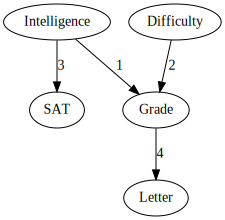

In [364]:
dg = graphviz.Digraph()
for (v,i) in vertexEncodings
    pycall(dg["node"], PyCall.PyObject, string(uppercase(Char(i+96))), v)
end

for rownum in 1:size(edgesEncoded)[1]
    string(uppercase(Char(edgesEncoded[rownum][1]+96)))*string(uppercase(Char(edgesEncoded[rownum][2]+96))) #*string(uppercase(Char(edgesEncoded[rownum][2]+96)))
    pycall(dg["edge"], PyCall.PyObject, string(uppercase(Char(edgesEncoded[rownum][1]+96))), string(uppercase(Char(edgesEncoded[rownum][2]+96))), label="$rownum")
end

dg

In [346]:
epsilon(bn, "SAT", "Grade", 2)

([2,5],3.9410283949802694e-5)

In [347]:
type ModelWithBN
    m::model
    vertexEncodings::Dict{ASCIIString,Int64}
    edgesEncoded::Array{Array{Int64,1},1}
end

In [348]:
function epsilon(BN::ModelWithBN, node_i::ASCIIString, node_j::ASCIIString, d::Int)
    epsilon(BN.m, BN.vertexEncodings[node_i], BN.vertexEncodings[node_j],d)
end

epsilon (generic function with 2 methods)

In [349]:
bn = ModelWithBN(m,vertexEncodings, edgesEncoded)

ModelWithBN(model(5,[2,2,3,2,2],100000x5 Array{Int64,2}:
 0  0  1  0  0
 0  0  0  1  1
 1  0  2  0  0
 0  0  2  0  0
 1  1  0  1  1
 0  0  1  0  0
 0  0  2  0  0
 0  0  0  0  1
 0  0  1  0  1
 0  0  1  0  0
 0  0  1  0  0
 0  1  0  1  1
 0  0  0  0  1
 ⋮            
 0  0  1  0  0
 1  1  2  1  0
 0  0  1  0  1
 0  0  0  0  1
 0  0  2  0  0
 0  0  1  0  0
 0  1  0  0  1
 1  1  1  1  0
 0  1  0  0  0
 1  0  1  1  0
 1  1  0  1  1
 0  0  2  0  0),Dict("Intelligence"=>2,"Difficulty"=>1,"SAT"=>4,"Grade"=>3,"Letter"=>5),[[2,3],[1,3],[2,4],[3,5]])

In [350]:
function computeEpsilonArray(BN::ModelWithBN, d::Int)
    for i in 1:1 #length(BN.edgesEncoded)
        return [epsilon(BN.m,BN.edgesEncoded[i][1], BN.edgesEncoded[i][2],d ) for i in 1:length(BN.edgesEncoded)]
    end
end

computeEpsilonArray (generic function with 1 method)

In [351]:
a=computeEpsilonArray(bn,2)

4-element Array{Tuple{Union{Array{Any,1},Array{Int64,1}},Float64},1}:
 ([4,5],0.027708964861958035)
 ([5],0.016717629711182107)  
 ([3],0.22425733287320757)   
 ([2],0.1807663791582597)    

In [352]:
epsilonArray[1]

0.0

In [367]:
a[1][2]

0.027708964861958035

In [371]:
Pkg.add("Formatting")

INFO: Cloning cache of Formatting from git://github.com/lindahua/Formatting.jl.git
INFO: Installing Formatting v0.1.4
INFO: Package database updated


In [372]:
using Formatting

In [377]:
fmt = "%1.2f"
s = sprintf1( fmt, 3.14159 )

"3.14"

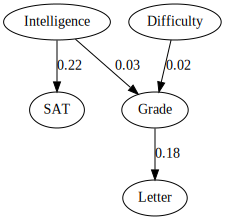

In [378]:
dg = graphviz.Digraph()
for (v,i) in vertexEncodings
    pycall(dg["node"], PyCall.PyObject, string(uppercase(Char(i+96))), v)
end

for rownum in 1:size(edgesEncoded)[1]
    label=sprintf1("%1.2f", a[rownum][2])
    string(uppercase(Char(edgesEncoded[rownum][1]+96)))*string(uppercase(Char(edgesEncoded[rownum][2]+96))) #*string(uppercase(Char(edgesEncoded[rownum][2]+96)))
    pycall(dg["edge"], PyCall.PyObject, string(uppercase(Char(edgesEncoded[rownum][1]+96))), string(uppercase(Char(edgesEncoded[rownum][2]+96))), label="$label")
end

dg